# Approximate Nearest Neighbours Search

Sometimes, when we are processing a user query, it may be **acceptable to retrieve a "good guess"** of 
nearest neighbours to the query **instead of true nearest neighbours**. In those cases, one can use an algorithm which doesn't guarantee to return the actual nearest neighbour in every case, **in return for improved speed or memory savings**. Thus, with the help of such algorithms one can do a **fast approximate search in a very large dataset**. Today we will expore two approaches based on graphs and trees.

This is what we are going to do in this lab: 

1. Build a *navigable* small-world graph;
2. Build a k-d tree;
3. Try `Annoy`. 

## 0. Dataset preparation
We will utilize [dataset with curious facts](https://raw.githubusercontent.com/IUCVLab/information-retrieval/main/datasets/facts.txt). Using trained `doc2vec` [model](https://github.com/jhlau/doc2vec) (Associated Press News DBOW (0.6GB), we will infer vectors for every fact and normalize them.

### 0.1. Loading doc2vec model

In [85]:
from gensim.models.doc2vec import Doc2Vec

# unpack a model into 3 files and target the main one
# doc2vec.bin  <---------- this
# doc2vec.bin.syn0.npy
# doc2vec.bin.sin1neg.npy
model = Doc2Vec.load('doc2vec.bin', mmap=None)
print(type(model))
print(type(model.infer_vector(["to", "be", "or", "not"])))

<class 'gensim.models.doc2vec.Doc2Vec'>
<class 'numpy.ndarray'>


### 0.2. Reading data

In [86]:
import urllib.request
data_url = "https://raw.githubusercontent.com/IUCVLab/information-retrieval/main/datasets/facts.txt"
file_name= "facts.txt"
urllib.request.urlretrieve(data_url, file_name)

facts = []
with open(file_name) as fp:
    for cnt, line in enumerate(fp):
        facts.append(line.strip('\n'))

### 0.3. Transforming sentences into vectors

In [87]:
import nltk
import numpy as np

def word_tokenize(sentence):
    return nltk.word_tokenize(sentence.lower())

def get_words_from_sentence(sentences):
    for sentence in sentences: 
        yield word_tokenize(sentence.split('.', 1)[1])

sent_vecs = np.array(list(model.infer_vector(words) for words in get_words_from_sentence(facts)))

### 0.4. Norming vectors (not graded)

Complete the method of vector norming, you can copy your code from previous homework.

In [88]:
def norm_vectors(A):
    An = A.copy()
    return np.array(np.nan_to_num([i / np.linalg.norm(i) for i in An], nan=0))

def find_k_closest(query, dataset, k=5):    
    index = list((i, v, np.dot(query, v)) for i, v in enumerate(dataset))    
    return sorted(index, key=lambda pair: pair[2], reverse=True)[:k]

sent_vecs_normed = norm_vectors(sent_vecs)

## 1. [35] Implementing Navigable Small World graph search

Now you need to implement an efficient search procedure which would utilize small world properties. Starting from the random node, at each step you should move towards the closest node (in terms of **cosine simiarity**, in our case), meanwhile keeping and refreshing top-K nearest neighbours collection. 

### 1.1. [30] Complete NSW index construction stage for this implementation

You can refer to the `Nearest_Neighbor_Insert` algorithm which pseudocode is given in section 5 (p. 65) of the [original paper](https://publications.hse.ru/mirror/pubs/share/folder/x5p6h7thif/direct/128296059).

In [89]:
import random
import sortedcontainers
import numpy as np
from scipy.spatial import distance
from numpy.linalg import norm as vector_norm
import pickle

class Node:
    ''' Graph node class. Major properties are `value` to access embedding and `neighbourhood` for adjacent nodes '''
    def __init__(self, value, idx, label):
        self.value = value
        self.label = label
        self.idx = idx
        self.neighbourhood = set()
        
    def __repr__(self):
        return f"`#{self.idx}: '{self.label} ~ {self.value}' ~ [{self.neighbourhood}]`"
        
class NSWGraph:    
    ## NB: by default constructor uses euclidean distance
    ## Next block asks you to implement cosine distance
    def __init__(self, values=None, dist=None):
        '''Values are tuples or lists of (vector, label)'''
        self.dist = dist if dist else self.eucl_dist
        self.nodes = [Node(node[0], i, node[1]) for i, node in enumerate(values)] if values else []

    def eucl_dist(self, v1, v2):
        return distance.euclidean(v1, v2)
          
    def search_nsw_basic(self, query, visitedSet, candidates, result, top=5, guard_hops=100, callback=None):
        ''' basic algorithm, takes vector query and returns a pair (nearest_neighbours, hops)'''
        # taking random node as an entry point
        tmpResult = sortedcontainers.SortedList()
        entry = random.randint(0, len(self.nodes) - 1)
        if entry not in visitedSet:
            candidates.add((self.dist(query, self.nodes[entry].value), entry))
        tmpResult.add((self.dist(query, self.nodes[entry].value), entry))
        
        hops = 0
        while hops < guard_hops:
            hops += 1
            if len(candidates) == 0: break
            
            # 6 get element c closest from candidates (see paper 4.2.)
            # 7 remove c from candidates
            closest_dist, сlosest_id = candidates.pop(0)
            
            # k-th best of global result
            # new stop condition from paper
            # if c is further than k-th element from result
            # than break repeat
            #! NB this statemrnt from paper will not allow to converge in first run.
            #! thus we use tmpResult if result is empty
            if len(result or tmpResult) >= top:
                if (result or tmpResult)[top-1][0] < closest_dist: break

            #  for every element e from friends of c do:
            for e in self.nodes[сlosest_id].neighbourhood:
                # 13 if e is not in visitedSet than
                if e not in visitedSet:                   
                    d = self.dist(query, self.nodes[e].value)
                    # 14 add e to visitedSet, candidates, tempRes
                    visitedSet.add(e)
                    candidates.add((d, e))
                    tmpResult.add((d, e))
                    
            if callback is not None:
                callback(self.nodes[сlosest_id].value, tmpResult)

        return tmpResult, hops
        
    def multi_search(self, query, attempts=1, top=5):   
        '''Implementation of `K-NNSearch`, but without keeping the visitedSet'''

        # share visitedSet among searched. Paper, 4.2.p2
        visitedSet, candidates, result = set(), sortedcontainers.SortedList(), sortedcontainers.SortedList()
        
        for i in range(attempts):
            closest, hops = self.search_nsw_basic(query, visitedSet, candidates, result, top=top)
            result.update(closest)
            result = sortedcontainers.SortedList(set(result))
        return [v for k, v in result[:top]]
    

    def build_navigable_graph(self, values, attempts=3, verbose=False, M=None):
        '''Accepts container with values. Returns list with graph nodes'''
        # Add verticals to the graph
        for i in range(len(values)):
            self.nodes.append(Node(values[i][0], i, values[i][1]))

        # The tests indicate [36] that at least for Euclid data with
        # d = 1...20, the optimal value for number of neighbors to
        # connect (f) is about 3d
        d = len(values[0][0])
        f = 3 * d if M is None else M
        if verbose:
            print(f"Data dimensionality detected is {d}. regularity = {f}")
        # Create edges
        for i in range(len(values)):
            val = values[i][0]
            neighbours = self.multi_search(val, attempts=attempts, top=f)
            self.nodes[i].neighbourhood.update(neighbours)
            for n in neighbours:
                self.nodes[n].neighbourhood.add(i)
            if verbose:
                if i * 10 % len(values) == 0:
                    print(f"\t{100 * i / len(values):.2f}% of graph construction")

### 1.2. [5] Implement cosine distance

In [90]:
def cosine(a, b):
    return 1 - (norm_vectors([a]) @ norm_vectors([b]).T)[0][0]

### 1.3. Test your search engine

In [91]:
# Test with euclidian distance
g = NSWGraph()

data = [([0, 0], "a"), ([0, 0], "a"), ([100, 101], "b"), ([100, 100], "b")]
data += [([1, 0], "a"), ([1, 0], "a"), ([101, 101], "b"), ([101, 100], "b")]
data += [([2, 0], "a"), ([2, 0], "a"), ([102, 101], "b"), ([102, 100], "b")]
data += [([3, 0], "a"), ([3, 0], "a"), ([103, 101], "b"), ([104, 100], "b")]

g.build_navigable_graph(data, verbose=True)

q = [0, 0]
print(f"Euclidean searching for {q}:")

for idx in g.multi_search(q):
    print(idx, g.nodes[idx])
    assert g.nodes[idx].value[0] < 10 and g.nodes[idx].value[1] < 10, f"{g.nodes[idx]} is not close to {q}"

Data dimensionality detected is 2. regularity = 6
	0.00% of graph construction
	50.00% of graph construction
Euclidean searching for [0, 0]:
0 `#0: 'a ~ [0, 0]' ~ [{0, 1, 4, 5, 6, 8, 9, 13}]`
1 `#1: 'a ~ [0, 0]' ~ [{0, 3, 4, 5, 6, 13, 14}]`
4 `#4: 'a ~ [1, 0]' ~ [{0, 1, 2, 4, 5, 8, 9, 12, 13}]`
5 `#5: 'a ~ [1, 0]' ~ [{0, 1, 4, 8, 9, 12, 13}]`
8 `#8: 'a ~ [2, 0]' ~ [{0, 4, 5, 8, 9, 12, 13}]`


In [92]:
# Test with cosine distance
g_cos = NSWGraph(dist=cosine)

g_cos.build_navigable_graph(data, verbose=True)

# [0, 0] has undefined cosine distance, so I changed it
q = [1, 0]
print(f"Cosine searching for {q}:")

for idx in g_cos.multi_search(q):
    # Should point the same direction
    print(idx, g_cos.nodes[idx])
    assert g_cos.nodes[idx].value[0] < 10 and g_cos.nodes[idx].value[1] < 10, f"{g_cos.nodes[idx]} is not close to {q}"

Data dimensionality detected is 2. regularity = 6
	0.00% of graph construction
	50.00% of graph construction
Cosine searching for [1, 0]:
4 `#4: 'a ~ [1, 0]' ~ [{5, 6, 7, 8, 9, 10, 12, 13, 15}]`
5 `#5: 'a ~ [1, 0]' ~ [{3, 4, 5, 7, 8, 9, 12, 13, 15}]`
8 `#8: 'a ~ [2, 0]' ~ [{1, 2, 3, 4, 5, 8, 9, 12, 13, 15}]`
9 `#9: 'a ~ [2, 0]' ~ [{4, 5, 8, 12, 13, 15}]`
12 `#12: 'a ~ [3, 0]' ~ [{2, 4, 5, 8, 9, 12, 13}]`


C:\Users\demo8\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in true_divide
  after removing the cwd from sys.path.


In [93]:
# Test on text data
word_graph = NSWGraph(dist=cosine)
word_data = []
for i in range(sent_vecs_normed.shape[0]):
    word_data.append((sent_vecs[i], facts[i]))
word_graph.build_navigable_graph(word_data, verbose=True, attempts=5)

q = "Good Mood"

q_embedding = model.infer_vector(word_tokenize(q))

for idx in word_graph.multi_search(q_embedding, attempts=5):
    print(word_graph.nodes[idx].label)

Data dimensionality detected is 300. regularity = 900
	0.00% of graph construction
68. Cherophobia is the fear of fun.
76. You breathe on average about 8,409,600 times a year
144. Dolphins sleep with one eye open!
97. 111,111,111 X 111,111,111 = 12,345,678,987,654,321
18. You cannot snore and dream at the same time.


### 1.4. [Bonus] Visualize the graph

Draw a picture with NSW graph with 100 2D nodes distributed uniformly in `[0, 1] x [0, 1]` range. Use `matplotlib` or `seaborn` or whatever.

In [37]:
# Library for working with graphs
!pip install networkx

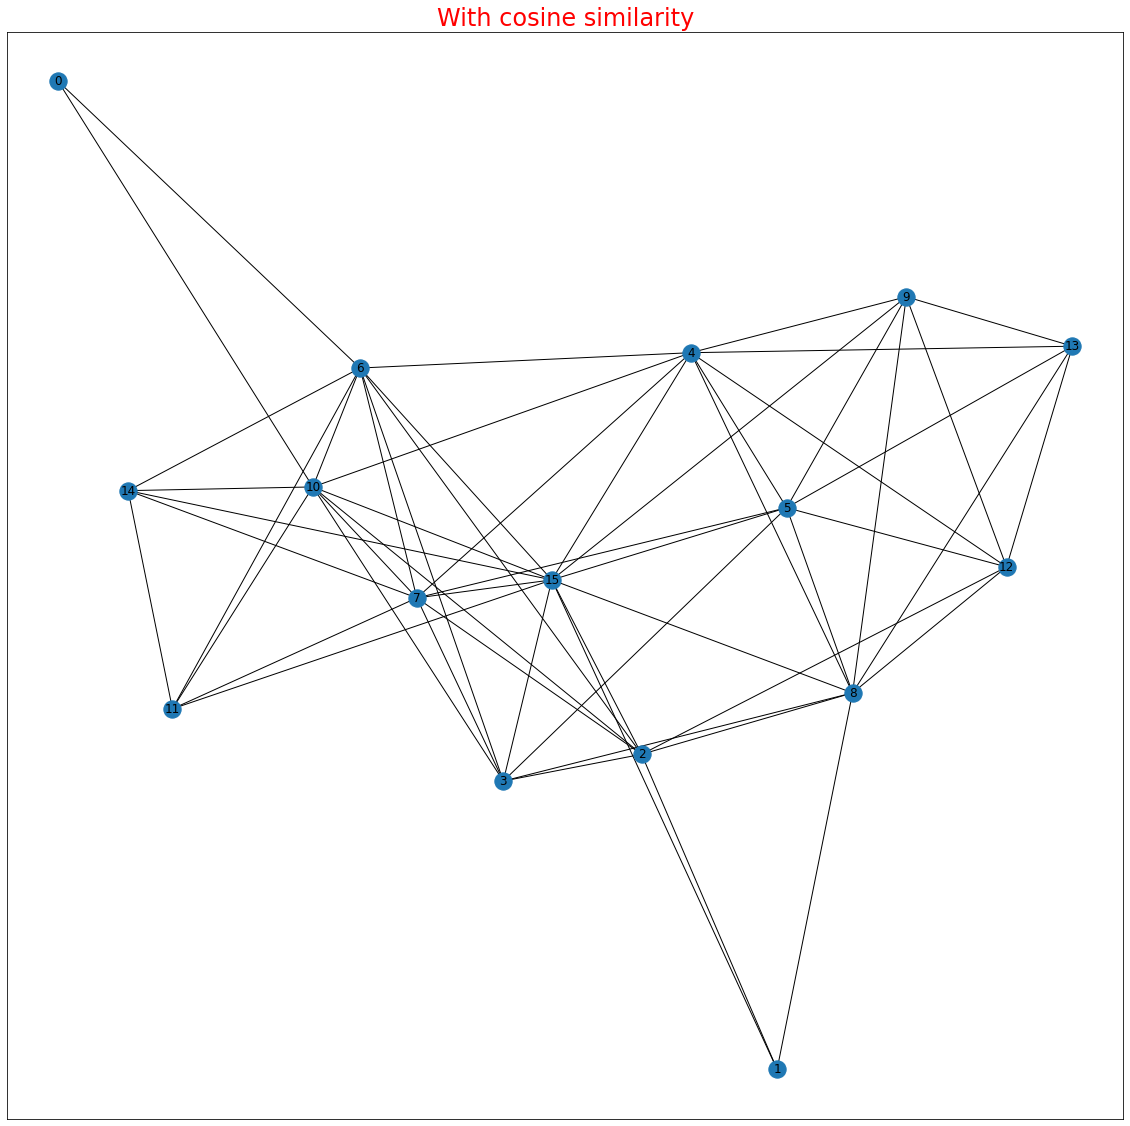

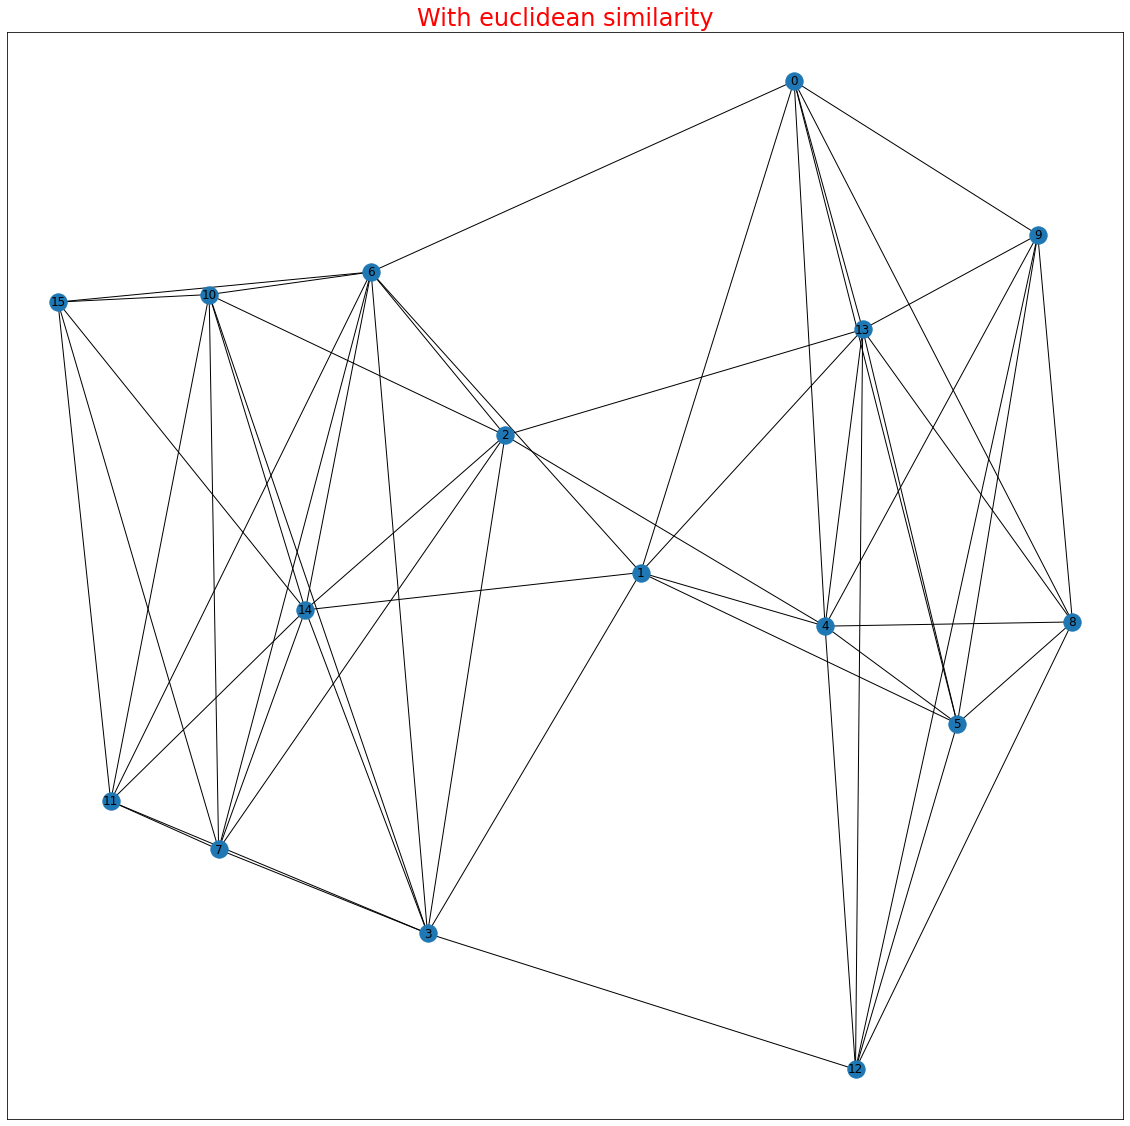

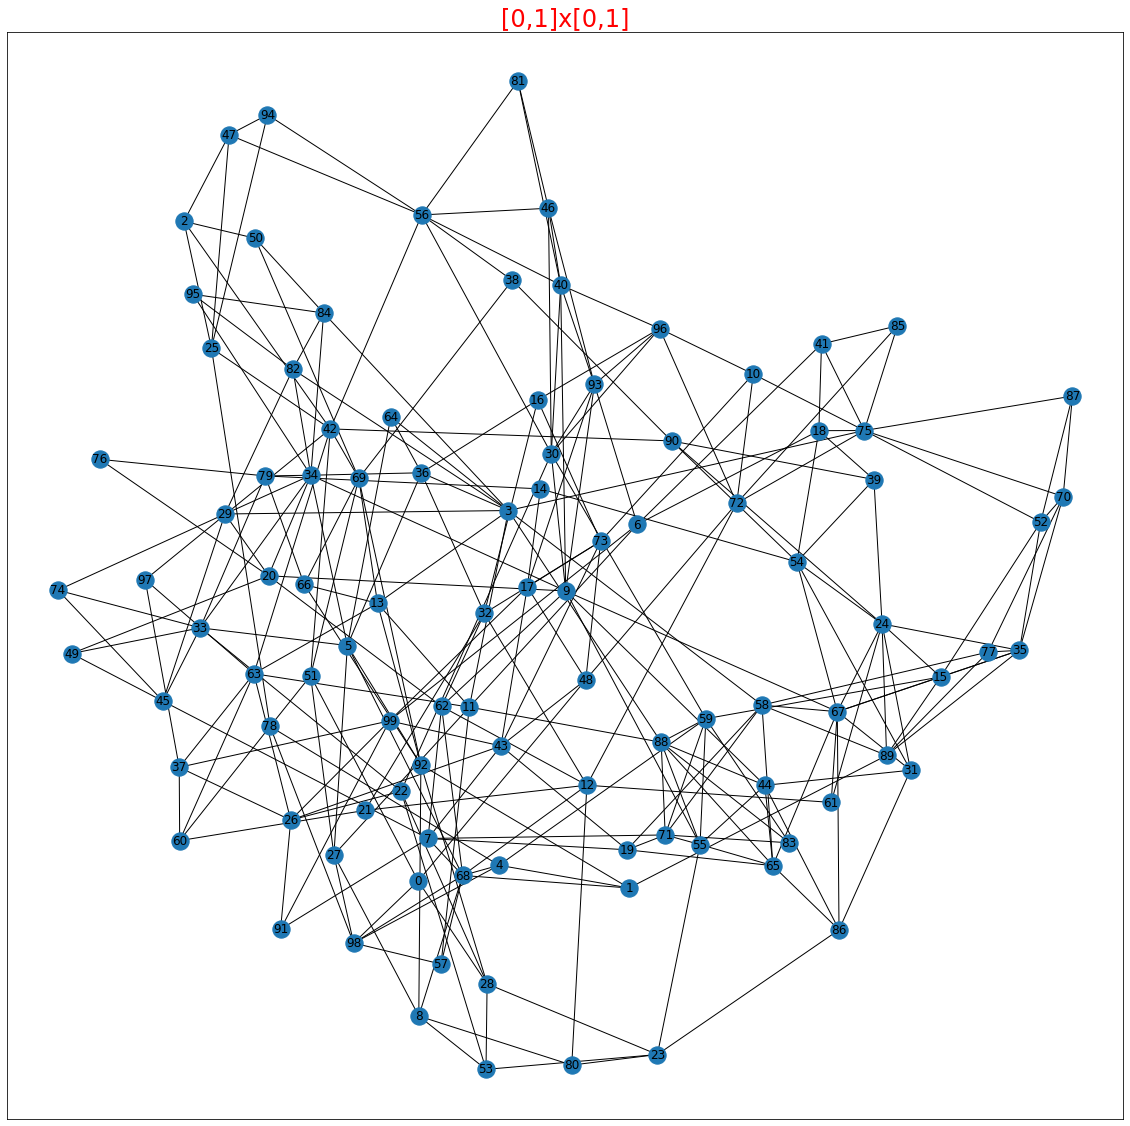

In [94]:
import networkx as nx
import matplotlib.pyplot as plt


def draw_graph(graph, title):
    vis_graph = nx.Graph()
    for i in graph.nodes:
        for j in i.neighbourhood:
            vis_graph.add_edge(i.idx, j)
    nx.draw_networkx(vis_graph)
    plt.rcParams["figure.figsize"] = (20,20)
    plt.rcParams['font.size'] = 20
    plt.rcParams['text.color'] = 'red'
    plt.title(title)
    plt.show()
    print("\n")


draw_graph(g_cos, "With cosine similarity")
draw_graph(g, "With euclidean similarity")

uniform_data = []
np.random.seed(42)
# Generate the data
for i in range(100):
    x = np.random.uniform(0, 1)
    y = np.random.uniform(0, 1)
    uniform_data.append(([x, y], "a"))

uniform_graph = NSWGraph(dist=cosine)
# Explicitly set the optimal num of neighbours M=3 to make graph more visual
uniform_graph.build_navigable_graph(uniform_data, M=3)
draw_graph(uniform_graph, "[0,1]x[0,1]")

## 2. [65] Implement KD-tree

Within this cell you will iteratively implement major methods of [kd-tree](https://en.wikipedia.org/wiki/K-d_tree) data structure. Biggest part of code is already written - just fill remaining gaps. 

This particular implementation is designed to be **non-homogeneous**, which means it **stores values only in leaf nodes**. But this doesn't limit you if you want to implement another approach.

Each leaf node can hold up to `leaf_capacity` items.

Item stored in an index is a tuple: `(coordinate_k_dim_vector, value)`.

Search requires only `coordinate_k_dim_vector` and returns relevant item(s).

### 2.0. Data generation

In [95]:
import time
import numpy as np 
from tqdm import tqdm_notebook
import matplotlib.pyplot as plt

K_random = 3
maxsize = 500000
start = time.time()
R = np.random.rand(maxsize, K_random)
R = [(row, "stub value {}".format(i)) for i, row in enumerate(R)]
print(R[:3])
finish = time.time()
print("{} rows generated in {:.2f} s".format(len(R), finish - start))

[(array([0.10312387, 0.90255291, 0.50525237]), 'stub value 0'), (array([0.82645747, 0.3200496 , 0.89552323]), 'stub value 1'), (array([0.38920168, 0.01083765, 0.90538198]), 'stub value 2')]
500000 rows generated in 0.65 s


### 2.1. Build procedure ###
`build_kd_tree()` method implements the core idea. This is the suggested idea, but you can modify it slightly:
- tree is non-homogenous, thus, items are stored in leaf nodes only.
- `self.pivot` should be assigned the median value for correspoinding `depth % K` coordinate.
- `left` variable should hold all the items <= than `self.pivot`.
- `right` variable should hold all the items > than `self.pivot`.
- `node_capacity=X` allows to store up to `X` items in a leaf node.

This is how it works for `K=2, node_capacity=2`:
![kd-tree](http://sprotasov.ru/files/kd.png)

### 2.2. [20+10+10+10+15] Complete the following methods (EXPENSIVE)
- `build_kd_tree`, 
- `kd_find_leaf`,
- `kd_insert_with_split`,
- `get_nn`,
- `get_in_range` (optional, to do real data test)

Test for each of them will come in following blocks.

In [96]:
import numpy as np
from scipy.spatial import distance

class Node:
    def __init__(self, K=None, parent=None):
        assert K is not None or parent, "Either `K` should be provided for root node, or `parent` for internal nodes"
        # Reference to parent node. Used in ANNS search
        self.parent = parent
        # depth start from 0. To compute dimension, relevant to the level, use (self.depth % self.K)
        self.depth = (parent.depth + 1) if parent else 0
        # K means number of vector dimensions
        self.K = parent.K if parent else K
        # value, which splits subspace into to parts using hyperplane: item[self.depth % self.K] == self.pivot
        # pivot is empty for any leaf node.
        self.pivot = None
        # left and right child nodes
        self.left = None
        self.right = None
        # collection of items
        self.items = None
        
    def build_kd_tree(self, items, leaf_capacity=4):
        '''Takes a list of items and arranges it in a kd-tree'''
        assert items is not None, "Please provide at least one point"
        # put all items in the node if they fit into limit
        if len(items) <= leaf_capacity:
            self.items = items
        # or else split items into 2 subnodes using median (?!) value
        else:
            self.items = None
            self.left = Node(parent=self)
            self.right = Node(parent=self)

            dim = self.depth % self.K
            sorted_items = sorted(items, key=lambda x: x[0][dim])
            pivot_ind = len(sorted_items) // 2
            # Shift to the last duplicate of pivot in the dimension dim (if exists)
            while pivot_ind + 1 < len(sorted_items) and \
                  sorted_items[pivot_ind][0][dim] == sorted_items[pivot_ind + 1][0][dim]:
                pivot_ind += 1

            # here you should write median value with respect to coordinate
            self.pivot = sorted_items[pivot_ind][0][dim]
            # those items, which are smaller or equal than the pivot value
            self.left.build_kd_tree(sorted_items[:pivot_ind])
            # those items, which are greater than the pivot value
            self.right.build_kd_tree(sorted_items[pivot_ind:])

        return self
    
    def kd_find_leaf(self, key):
        ''' returns a node where key should be stored (but can be not present)'''
        if self.pivot is None or self.items is not None: # leaf node OR empty root
            return self
        else:
            dim = self.depth % self.K
            # Walking throight the tree
            if self.pivot < key[dim]:
                return self.right.kd_find_leaf(key)
            return self.left.kd_find_leaf(key)
            
#     def kd_insert_no_split(self, item):
#         '''Naive implementation of insert into leaf node. It is not used in tests of this tutorial.'''
#         node = self.kd_find_leaf(item[0])
#         node.items.append(item)
        
    def kd_insert_with_split(self, item, leaf_capacity=4):
        '''This method recursively splits the nodes into 2 child nodes if they overflow `leaf_capacity`'''
        leaf = self.kd_find_leaf(item[0])
        if leaf.items == None:
            leaf.items = []
        leaf.items.append(item)
        if len(leaf.items) > leaf_capacity:
            leaf.build_kd_tree(leaf.items, leaf_capacity=leaf_capacity)
    # Return a list of items of all children
    def get_children(self):
        children = []
        if self.items != None:
            children = self.items
        else:
            left = self.left.get_children()
            right = self.right.get_children()
            children.extend(left)
            children.extend(right)
        return children

    def get_nn(self, key, knn):
        '''Return K approximate nearest neighbours for a given key'''
        node = self.kd_find_leaf(key)
        best = []
        while len(best) < knn:
            # Up to the parent
            root = node.parent
            # Go to the neighbour
            if root.left == node:
                child_content = root.right.get_children()
            else:
                child_content = root.left.get_children()
            best.extend(child_content)
            node = root
        best = sorted(best,key=lambda x: distance.euclidean(key, x[0]))
        return best[:knn]
    
    def get_in_range(self, lower_left_bound_key, upper_right_bound_key):
        '''Runs range query. Returns all items bounded by the given corners: `lower_left_bound_key`, `upper_right_bound_key`'''
        result = []
        lower = lower_left_bound_key[1]
        left = lower_left_bound_key[0]
        upper = upper_right_bound_key[1]
        right = upper_right_bound_key[0]
        if self.pivot is None or self.items is not None: # internal node OR empty root
            for i in self.items:
                coord = i[0]
                if (left <= coord[0] <= right) and (lower <= coord[1] <= upper):
                    result.append(i)
        else:
            dim = self.depth % self.K
            lim1 = lower_left_bound_key[dim]
            lim2 = upper_right_bound_key[dim]
            # Select a direction according to pivot and boundaries
            if self.pivot > lim2:
                ans = self.left.get_in_range(lower_left_bound_key, upper_right_bound_key)
                result.extend(ans)
            elif self.pivot < lim1:
                ans = self.right.get_in_range(lower_left_bound_key, upper_right_bound_key)
                result.extend(ans)
            # Pivot between boundaries
            else:
                ans1 = self.left.get_in_range(lower_left_bound_key, upper_right_bound_key)
                ans2 = self.right.get_in_range(lower_left_bound_key, upper_right_bound_key)
                result.extend(ans1)
                result.extend(ans2)
        return result

#### 2.2.1. Test that building time is growing linearly

C:\Users\demo8\Anaconda3\lib\site-packages\ipykernel_launcher.py:7: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  import sys


  0%|          | 0/10 [00:00<?, ?it/s]

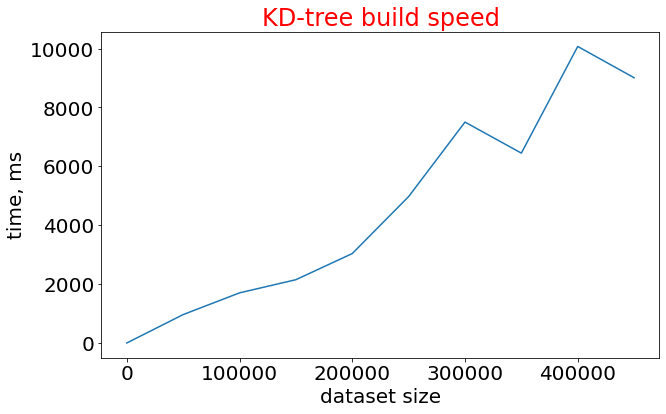

In [98]:
# sample 10, 20, ..., 100% of R
step = len(R) // 10
sizes, build_times = [], []

# tqdm_notebook draws a progress bar. If it doesnt't work in your environment, just remove it.
for size in tqdm_notebook(range(1, len(R) + 1, step)):
    sample = R[:size]
    start = time.time()
    kdtree = Node(K=K_random).build_kd_tree(sample)
    finish = time.time()
    sizes.append(size)
    build_times.append((finish - start) * 1000)
    
    
fig = plt.figure(figsize=(10, 6))
a = plt.axes()
a.set_xlabel('dataset size')
a.set_ylabel('time, ms')
plt.plot(sizes, build_times)
plt.title("KD-tree build speed")
plt.show()

#### 2.2.2. Test that search time is fast and of a millisecond scale

C:\Users\demo8\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  """


  0%|          | 0/10 [00:00<?, ?it/s]

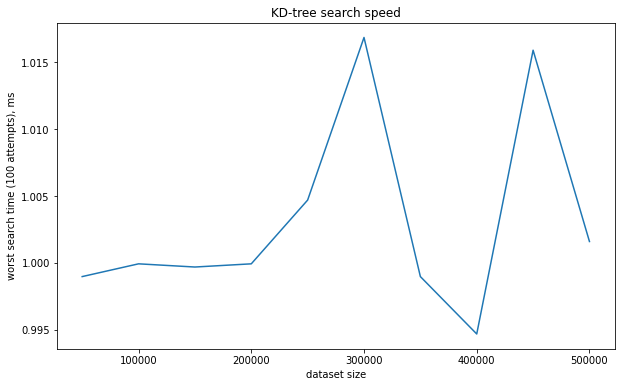

In [18]:
step = len(R) // 10
sizes, search_times = [], []

for size in tqdm_notebook(range(step, len(R) + 1, step)):
    kdtree = Node(K=K_random).build_kd_tree(R[:size])
    
    iterations = 100
    duration = None
    for i in range(iterations):
        x = R[random.randint(0, len(R) - 1)]
        start = time.time()
        kdtree.kd_find_leaf(x[0])
        finish = time.time()
        duration = max(duration, finish - start) if duration else finish - start
        
    sizes.append(size)
    search_times.append(duration * 1000)
    
    
fig = plt.figure(figsize=(10, 6))
a = plt.axes()
a.set_xlabel('dataset size')
a.set_ylabel('worst search time (100 attempts), ms')
plt.plot(sizes, search_times)
plt.title("KD-tree search speed")
plt.show()

#### 2.2.3. Insertion ###
Inserting speed should be growing similar to `log` function with respect to data size.

Now let's see how fast the tree depth is growing for different capacity set-ups. Implement the remaining part of `kd_insert_with_split()` and run the test.

C:\Users\demo8\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  


  0%|          | 0/100 [00:00<?, ?it/s]

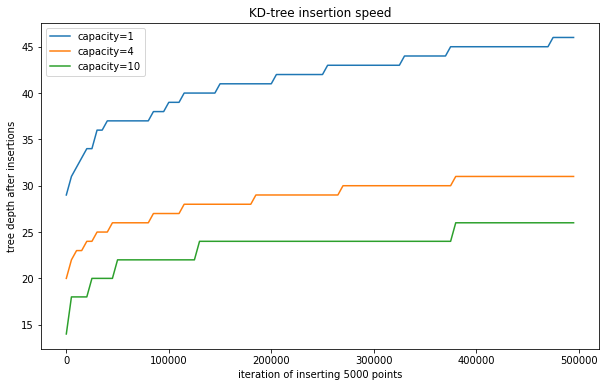

In [19]:
step = 5000
sample_size = 500000
trees = [
            Node(K=3),
            Node(K=3),
            Node(K=3)
]
capacities = [1, 4, 10]


sizes, depths = [], [[], [], []]
max_depth = [0, 0, 0]
for i in tqdm_notebook(range(0, sample_size, step)):
    for item in R[i:i+step]:
        for t in range(3):
            trees[t].kd_insert_with_split((item[0], "stub value test 1.C."), leaf_capacity=capacities[t])
            max_depth[t] = max(trees[t].kd_find_leaf(item[0]).depth, max_depth[t])
    sizes.append(i)
    for t in range(3):
        depths[t].append(max_depth[t])

fig = plt.figure(figsize=(10, 6))
a = plt.axes()
a.set_xlabel('iteration of inserting 5000 points')
a.set_ylabel('tree depth after insertions')
plt.plot(sizes, depths[0], label="capacity={}".format(capacities[0]))
plt.plot(sizes, depths[1], label="capacity={}".format(capacities[1]))
plt.plot(sizes, depths[2], label="capacity={}".format(capacities[2]))
plt.legend(loc="upper left")
plt.title("KD-tree insertion speed")
plt.show()

#### 2.2.4. ANNS search ### 
This block tests `get_nn()` method, which performs approximate nearest neighbour search. Please, complete this method. After you run this block you will see how NN count influences search speed. It should be linear.

In [84]:
# NN SEARCH
kdtree = Node(K=K_random).build_kd_tree(R)
times = []
nns = [10, 100, 1000, 10000, 20000, 40000]
iterations = 10
for nn in tqdm_notebook(nns):
    start = time.time()
    for t in range(iterations):
        x = R[random.randint(0, len(R) - 1)]
        kdtree.get_nn(x[0], nn)
    finish = time.time()
    times.append((finish - start) * 1000 / iterations)

fig = plt.figure(figsize=(10, 6))
a = plt.axes()
a.set_xlabel('How many NNs we request')
a.set_ylabel('time of search, ms')
plt.title("KD-tree depth growth with insertions")
plt.plot(nns,times)
plt.show()

TypeError: __init__() got an unexpected keyword argument 'K'

### 2.3. Real data (self studying)

Please refer to [this notebook](08%20Approximate%20NN%20Search%20trees%20template.ipynb#3.-Real-data) to see how the methods work with real data on a map.

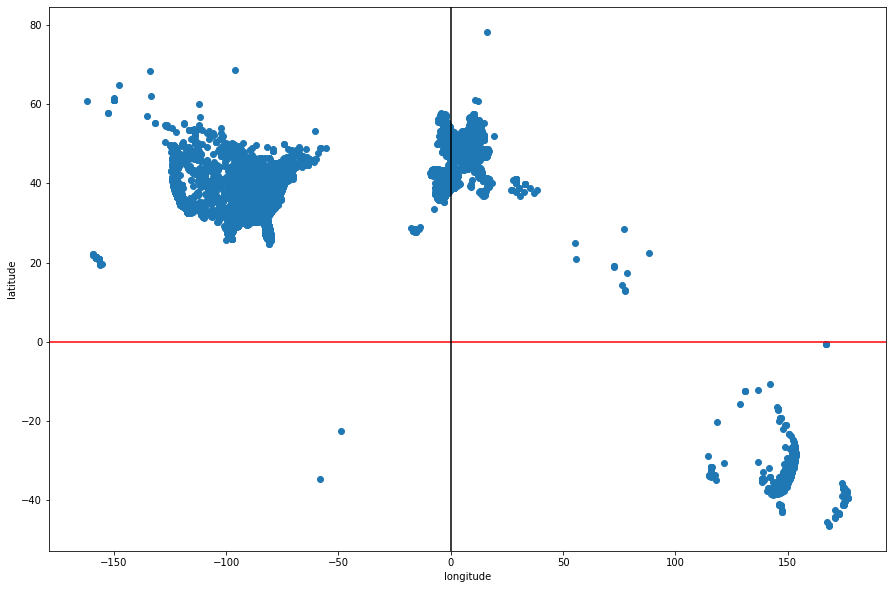

In [21]:
# replace filename if you want to use other index file
import pickle
with open("poi_sample001.pickle", "rb") as f:
    dataset = pickle.load(f)

# let's sample 20000 of points to draw
step = len(dataset) // 20000

X = [v[0][0] for v in dataset[::step]]
Y = [v[0][1] for v in dataset[::step]]

plt.figure(figsize=(15, 10))
a = plt.axes()
a.set_xlabel('longitude')
a.set_ylabel('latitude')
plt.axhline(0, color='red')
plt.axvline(0, color='black')
plt.scatter(X, Y)
plt.show()

In [22]:
K_real = 2
start = time.time()
kdtree = Node(K=K_real).build_kd_tree(dataset)
finish = time.time()
print("Index build in {:.2f} sec.".format(finish - start))

Index build in 4.16 sec.


In [23]:
paris = [2.334083, 48.853260]
boulder = [-105.205606, 40.063987]
sidney = [151.211122, -33.874236]

paris_nn = [v for v in kdtree.get_nn(paris, 5000) if 'Shop' in v[1]]
boulder_nn = [v for v in kdtree.get_nn(boulder, 5000) if "College" in v[1]]
sidney_nn = [v for v in kdtree.get_nn(sidney, 5000) if "Food" in v[1]]

# print to check that places you found are actually in neighbourhood
print("Australia, Sidney, food", sidney_nn[:5])

Australia, Sidney, food [([151.208053589, -33.8758888245], 'Health Plus, Food & Beverages, Specialty. AU, Sydney, Shop 10, 324 Pitt St'), ([151.205154419, -33.8717842102], 'Cabinet Corporate Hospitality The, Food & Beverages, Liquor & Beverages. AU, Sydney, 414 Kent St'), ([151.204437256, -33.8766212463], 'Uniliquor, Food & Beverages, Liquor & Beverages. AU, Sydney, 377 Sussex St'), ([151.202468872, -33.8838043213], "McDonald's Family Restaurants, Fast Food, . AU, Broadway, 863 George St"), ([151.223999023, -33.8751792908], 'Hunter Valley Food Services, Shopping, Stationery & Office Supplies. AU, Potts Point, 33 Bayswater Rd')]


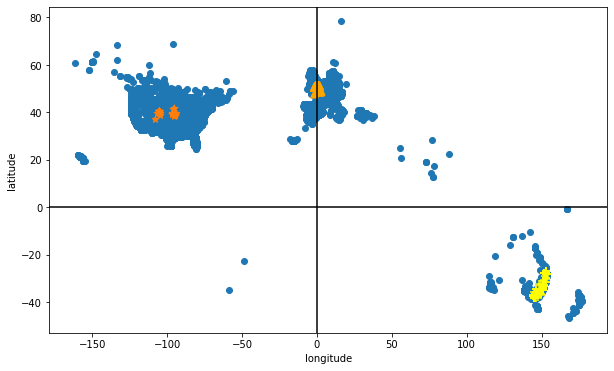

In [24]:
X = [v[0][0] for v in dataset[::step]]
Y = [v[0][1] for v in dataset[::step]]
BX, BY = [v[0][0] for v in boulder_nn], [v[0][1] for v in boulder_nn]
PX, PY = [v[0][0] for v in paris_nn], [v[0][1] for v in paris_nn]
SX, SY = [v[0][0] for v in sidney_nn], [v[0][1] for v in sidney_nn]
plt.figure(figsize=(10, 6))
a = plt.axes()
a.set_xlabel('longitude')
a.set_ylabel('latitude')
plt.axhline(0, color='black')
plt.axvline(0, color='black')
plt.scatter(X, Y)
plt.scatter(BX, BY, marker="*", s=50)
plt.scatter(PX, PY, marker="^", s=50, color="orange")
plt.scatter(SX, SY, marker="+", s=50, color='yellow')
plt.show()

In [25]:
low, high = [-76.0, 38.0], [-72.0, 42.0]
region = kdtree.get_in_range(low, high)
print("Found: {} items".format(len(region)))

Found: 15583 items


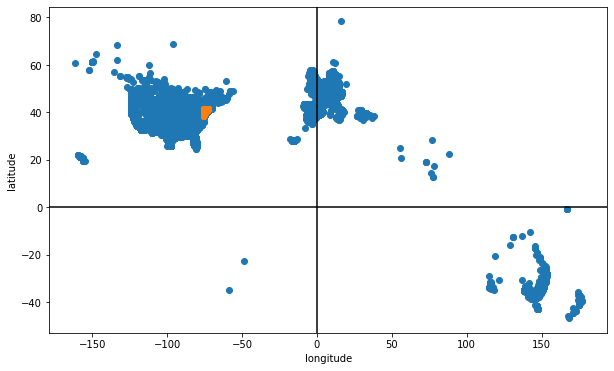

In [26]:

X = [v[0][0] for v in dataset[::step]]
Y = [v[0][1] for v in dataset[::step]]
RX, RY = [v[0][0] for v in region], [v[0][1] for v in region]
plt.figure(figsize=(10, 6))
a = plt.axes()
a.set_xlabel('longitude')
a.set_ylabel('latitude')
plt.axhline(0, color='black')
plt.axvline(0, color='black')
plt.scatter(X, Y)
plt.scatter(RX, RY, marker=".", s=50)
plt.show()

## 3. Bonus with [Annoy](https://github.com/spotify/annoy) library ## 

Now you have your own index data structure. How far is it from industrial implementations?

First of all, let's install and import the requirement. Just run it.

In [28]:
# !pip install --user annoy
from annoy import AnnoyIndex

### 3.1. Build the index upon the same data using 10 trees, cosine distance

In [82]:
index = AnnoyIndex(K_random, 'dot')
for i in range(len(R)):
    index.add_item(i, R[i][0])
index.build(10)


True

Let's run a test for KNN search. 

Is it much faster?

Is it assimpotically faster?

C:\Users\demo8\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  


  0%|          | 0/6 [00:00<?, ?it/s]

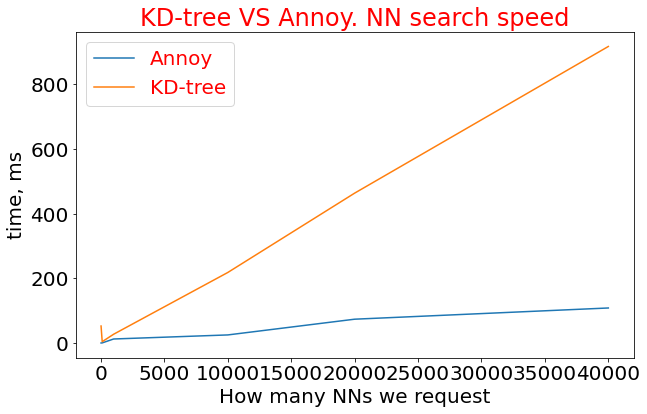

In [83]:
# NN SEARCH
times_annoy = []
nns = [10, 100, 1000, 10000, 20000, 40000]
iterations = 10
for nn in tqdm_notebook(nns):
    start = time.time()
    for t in range(iterations):
        x = R[random.randint(0, len(R) - 1)]
        index.get_nns_by_vector(x[0], nn)
    finish = time.time()
    times_annoy.append((finish - start) * 1000 / iterations)

fig = plt.figure(figsize=(10, 6))
a = plt.axes()
a.set_xlabel('How many NNs we request')
a.set_ylabel('time, ms')
plt.plot(nns, times_annoy, label='Annoy')
# you can also build times array on the same graph
plt.plot(nns, times, label='KD-tree')
plt.legend(loc="upper left")
plt.title("KD-tree VS Annoy. NN search speed")
plt.show()

Comment: it's much faster, and it looks like O(log(n)) vs O(n), but I didn't find
a proof that Annoy is asymptotically faster in NN searching.